In [12]:
import pennylane as qml
from pennylane import CVNeuralNetLayers
from pennylane.optimize import AdamOptimizer
import numpy as np
from functools import reduce
from tqdm import tqdm
import dill
from matplotlib import pyplot as plt
import torch
from torch.optim import Adam
import random

In [13]:
wires = 6
layers = 2

weights = torch.rand((layers, 3*wires), requires_grad=True)
rotations = torch.rand((layers, wires), requires_grad=True)

dev = qml.device('lightning.qubit', wires=wires)

epoch = 200
batch_size = 500

print(dev)

<lightning.qubit device (wires=6) at 0x154220c8c10>


### Accuracy
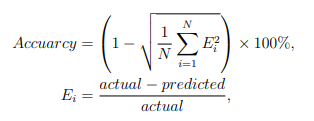

In [14]:
def accuracy(predicted_sequence, true_sequence):
    return 1-torch.sqrt(torch.mean( torch.square((predicted_sequence - true_sequence)/true_sequence) ))

In [15]:


def ansatz(weights, rotations, depth = 4, layer = 1):
  for i in range(layer):
    for j in range(depth):
      qml.RX(weights[i, 3*j],   j)
      qml.RZ(weights[i, 3*j+1], j)
      qml.RX(weights[i, 3*j+2], j)
      
    for a in range(depth-1):
      qml.CNOT(wires=[a, a+1])
      qml.RZ(rotations[i, a], a+1)
      qml.CNOT(wires=[a, a+1])
    
    qml.CNOT(wires=[depth-1, 0])
    qml.RZ(rotations[i, -1], 0)
    qml.CNOT(wires=[depth-1, 0])
  
def encode(x, hidden_node, depth = 4):
  for i in range(depth//2):
    qml.RY(torch.arccos(x), i)
  for i in range(depth//2, depth):
    qml.RY(torch.arccos(hidden_node[0]), i)
  


@qml.qnode(dev, diff_method="adjoint", interface='torch')
def circuit(weights, rotations, x, hidden_state):
  """
  Return output and current hidden state
  """
  encode(x, hidden_state, depth=wires)
  ansatz(weights, rotations, depth=wires, layer=layers)
  out = qml.expval(
    qml.PauliZ(0) @
    qml.PauliZ(1) @
    qml.PauliZ(2)
    )
  hidden_state = qml.expval(
    qml.PauliZ(3) @
    qml.PauliZ(4) @
    qml.PauliZ(5)
    )

  return out, hidden_state 

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return (labels - predictions) ** 2

def cost(weights, rotations, X):
    loss = 0
    for xs, label in X:
      hidden_state = torch.zeros((1,))
      for x, y in zip(xs, torch.cat((xs[1:], label))):
        out = circuit(weights, rotations, x, hidden_state)
        prediction = out[0]
        hidden_state = out[1:]
      loss += square_loss(y, prediction)
    
    return loss/batch_size


  0%|          | 1/200 [00:06<21:23,  6.45s/it]

0.11008042097091675


100%|██████████| 200/200 [28:28<00:00,  8.54s/it]


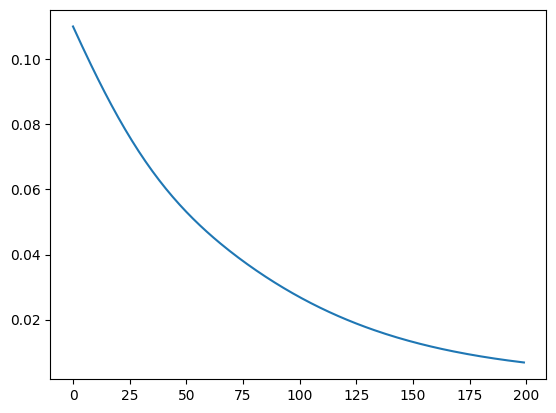

In [16]:

train, test = dill.load(open('temperature_processed.pkl', 'rb'))
train, test = train[:500], test[:500]

optimizer = Adam([weights, rotations], lr=0.001)

loss_history = []


def closure():
    optimizer.zero_grad()
    loss = cost(weights, rotations, train)
    loss.backward()
    
    return loss
  
loss_history = []
for i in tqdm(range(epoch)):
  loss = optimizer.step(closure)
  loss_history.append(loss.item())
  
  if i % 500 == 0:
    print(loss.item())

dill.dump((weights, rotations), open('params.pkl', 'wb'))

plt.plot(loss_history)
plt.show()



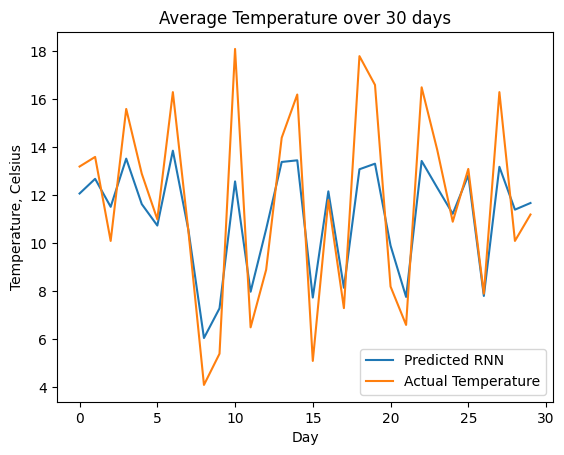

tensor(0.7781)

In [17]:
### Show example
scaler = dill.load(open("scaler.pkl", "rb"))
weights, rotations = dill.load(open('params.pkl', 'rb'))

#print(cost(weights, rotations, test))
predictions = []
true_values = []
with torch.no_grad():
    predictions = []  
    for xs, label in test[:30]:
        hidden_state = torch.zeros((1,))
        for x in xs:
            out = circuit(weights, rotations, x, hidden_state)
            prediction = out[0]
            hidden_state = out[1:]
        predictions.append(prediction)
        true_values.append(label)
    true_values = torch.Tensor(true_values)
    predictions = torch.Tensor(predictions)
    plt.title(f'Average Temperature over 30 days')
    plt.xlabel('Day')
    plt.ylabel('Temperature, Celsius')
    plt.plot(scaler.inverse_transform(predictions.reshape(-1, 1)), label='Predicted RNN')
    plt.plot(scaler.inverse_transform(true_values.reshape(-1, 1)), label='Actual Temperature')
plt.legend()
plt.show()

accuracy(predictions, true_values)